In [1]:
import numpy as np
import os
import tensorflow as tf
import shutil
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [2]:
def create_sorted_directories(base_dir):
    # Define the categories and their corresponding directories
    categories = ['Normal', 'Virus', 'Bacteria']
    for category in categories:
        category_dir = os.path.join(base_dir, category)
        os.makedirs(category_dir, exist_ok=True)

def sort_and_cleanup_images(base_dir):
    # Create target directories
    create_sorted_directories(base_dir)

    # Define paths to category directories
    normal_dir = os.path.join(base_dir, 'Normal')
    virus_dir = os.path.join(base_dir, 'Virus')
    bacteria_dir = os.path.join(base_dir, 'Bacteria')

    # Iterate over all files in the directory
    for subdir, dirs, files in os.walk(base_dir):
        for file in files:
            # Skip if we are in the already sorted directories
            if subdir in [normal_dir, virus_dir, bacteria_dir]:
                continue

            # Move file based on its name
            if 'bacteria' in file.lower():
                shutil.move(os.path.join(subdir, file), os.path.join(bacteria_dir, file))
            elif 'virus' in file.lower():
                shutil.move(os.path.join(subdir, file), os.path.join(virus_dir, file))
            else:
                shutil.move(os.path.join(subdir, file), os.path.join(normal_dir, file))

        # If the directory is empty, delete it
        if not os.listdir(subdir):
            shutil.rmtree(subdir, ignore_errors=True)

# Specify your train and test directories
train_dir = '/content/drive/MyDrive/chest_xray/train'
test_dir = '/content/drive/MyDrive/chest_xray/test'

# Run the sorting and cleanup function for both train and test directories
sort_and_cleanup_images(train_dir)
sort_and_cleanup_images(test_dir)

In [3]:
# Data Augmentation
train_idg = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range = 0.2,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_idg = ImageDataGenerator(
    rescale=1./255
)

val_idg = ImageDataGenerator(
    rescale=1./255.
)

In [4]:
# Data loading
train = train_idg.flow_from_directory(
    '/content/drive/MyDrive/chest_xray/train',
    class_mode='categorical',
    color_mode="rgb",
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=42
)

test = test_idg.flow_from_directory(
    '/content/drive/MyDrive/chest_xray/test',
    class_mode='categorical',
    color_mode="rgb",
    target_size=(224, 224),
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 5235 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


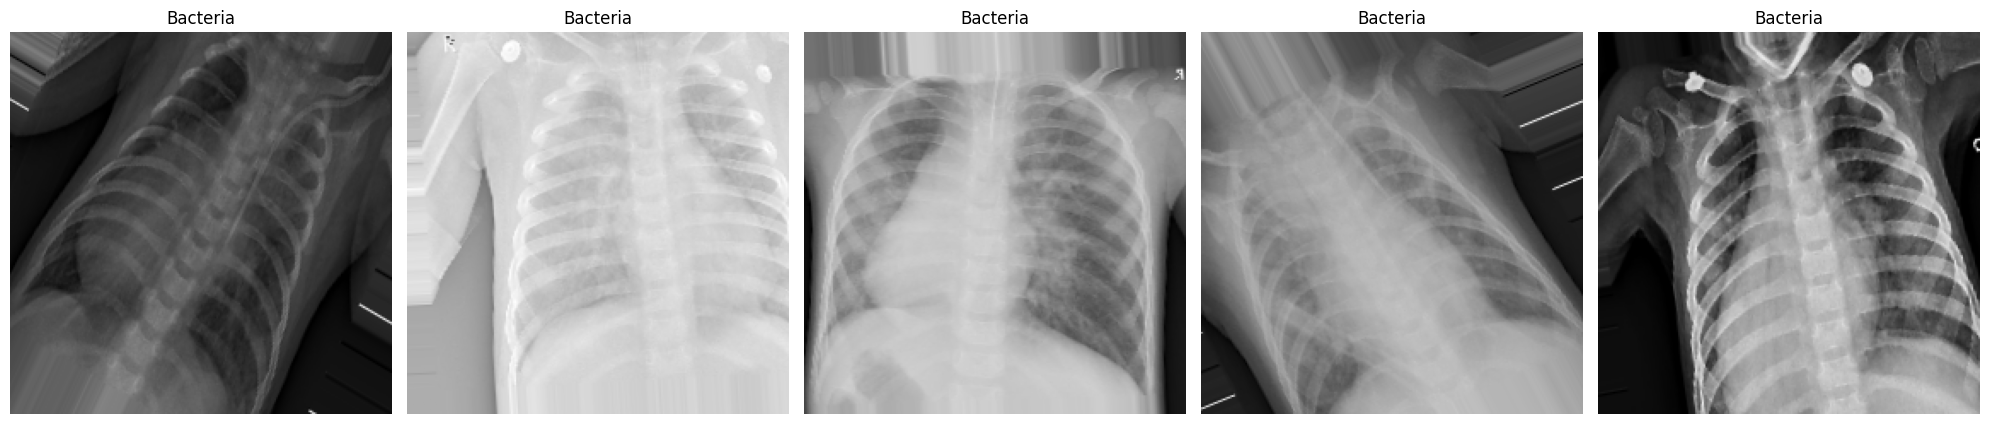

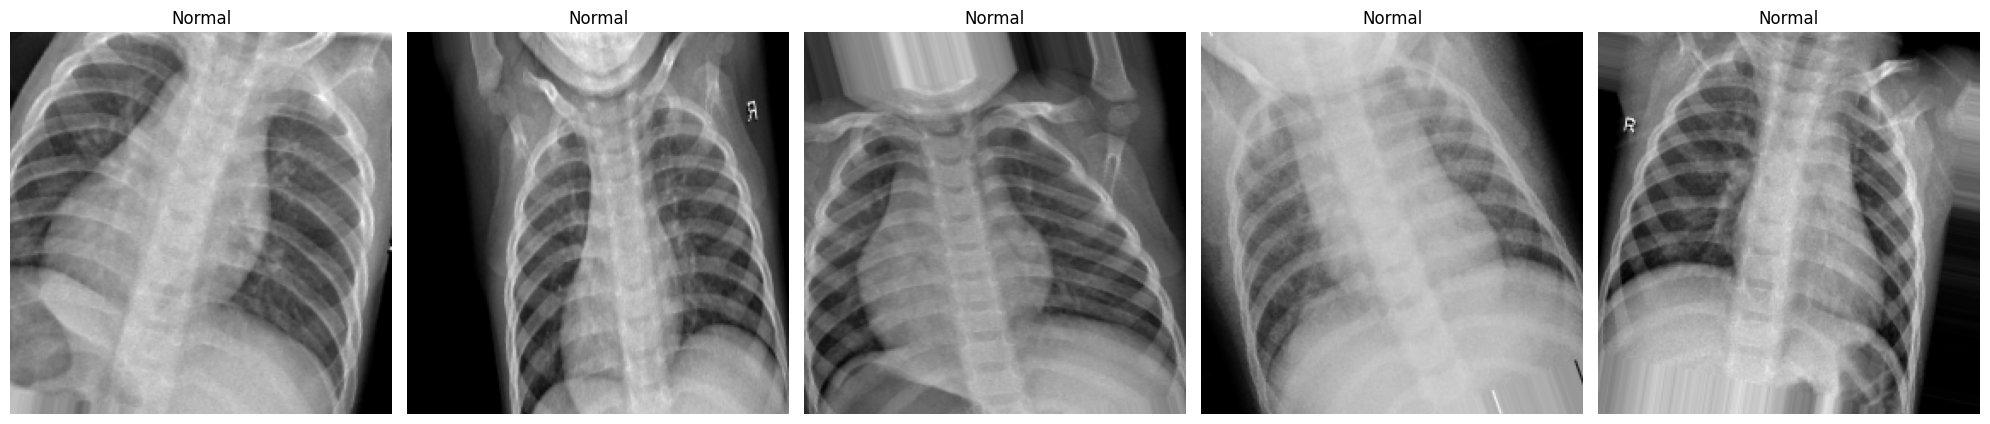

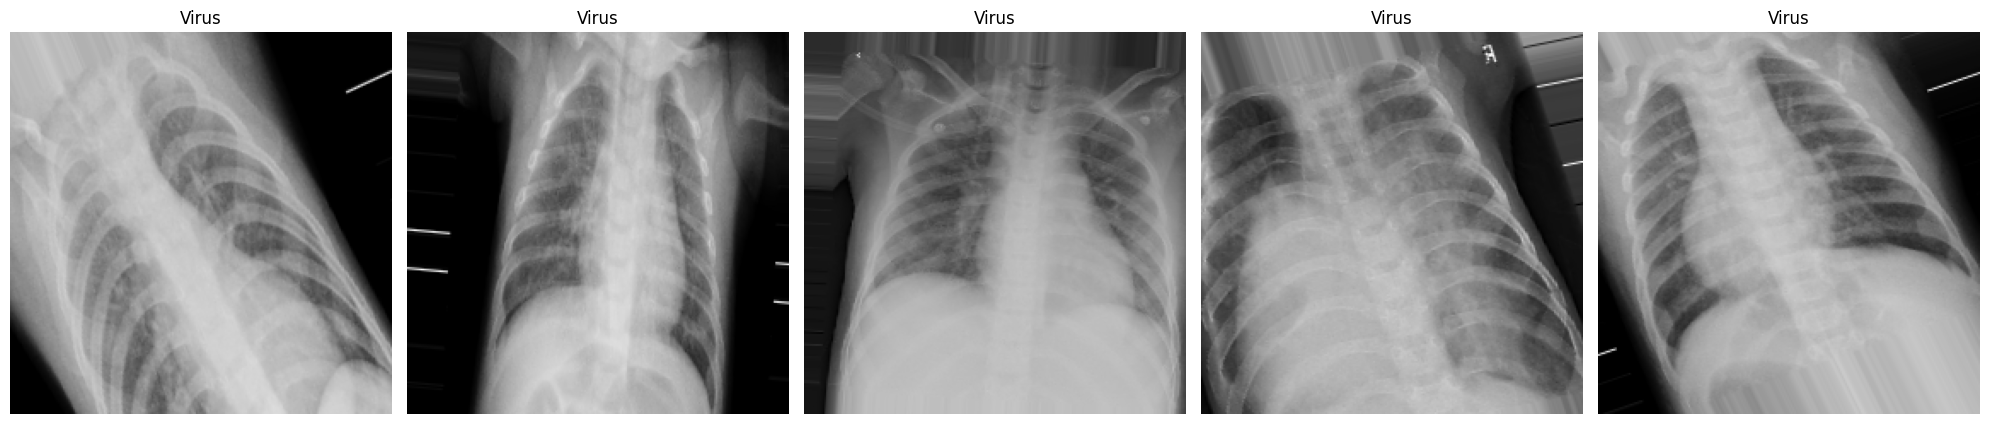

In [5]:
def plot_images(images_arr, labels_arr, class_labels):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, label, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        # Setting the title for each image to its corresponding label
        ax.set_title(class_labels[label])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Fetch and plot a batch of images from the train generator
class_indices = {v: k for k, v in train.class_indices.items()}  # Reverse the class_indices dictionary

images_to_plot = {i: [] for i in range(3)}  # Dictionary to hold 5 images for each category

# Loop until we collect 5 images for each category
while any(len(images) < 5 for images in images_to_plot.values()):
    images, labels = next(train)
    for i in range(3):  # There are three categories
        if len(images_to_plot[i]) < 5:  
            # Filter images by class
            images_by_class = images[np.argmax(labels, axis=1) == i]
            labels_by_class = np.argmax(labels[np.argmax(labels, axis=1) == i], axis=1)
            # Add images to our dictionary
            images_to_plot[i].extend(images_by_class[:5 - len(images_to_plot[i])])

# Plot the collected images for each category
for i in range(3):
    plot_images(images_to_plot[i], [i] * len(images_to_plot[i]), class_indices)

In [6]:
# Load up pretrained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [7]:
# Freeze layers of base model
for layer in base_model.layers[:144]:
  layer.trainable = False


In [8]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(3, activation='softmax')(x)

In [9]:
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=5,
                                            verbose=1,
                                            factor=0.3,
                                            min_lr=0.0001)

In [11]:
class_samples = {
    'Normal': len(os.listdir('/content/drive/MyDrive/chest_xray/train/Normal')),
    'Virus': len(os.listdir('/content/drive/MyDrive/chest_xray/train/Virus')),
    'Bacteria': len(os.listdir('/content/drive/MyDrive/chest_xray/train/Bacteria'))
}
# Total number of samples
total_samples = sum(class_samples.values())

# Class weights (inversely proportional to the class frequencies)
class_weights = {
    0: (1 / class_samples['Bacteria']) * (total_samples / 3.0),
    1: (1 / class_samples['Normal']) * (total_samples / 3.0),
    2: (1 / class_samples['Virus']) * (total_samples / 3.0),
}

In [12]:
# fit and train the model
history = model.fit(train,
                    validation_data=test,
                    epochs=30,
                    callbacks=[learning_rate_reduction],
                    class_weight=class_weights
)

Epoch 1/30
164/164 [==============================] - 789s 4s/step - loss: 1.1196 - accuracy: 0.4487 - val_loss: 2.2732 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 2/30
164/164 [==============================] - 152s 925ms/step - loss: 0.8675 - accuracy: 0.5454 - val_loss: 1.3367 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 3/30
164/164 [==============================] - 150s 913ms/step - loss: 0.8141 - accuracy: 0.5723 - val_loss: 1.5818 - val_accuracy: 0.4135 - lr: 0.0010
Epoch 4/30
164/164 [==============================] - 148s 903ms/step - loss: 0.7768 - accuracy: 0.5790 - val_loss: 5.0578 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 5/30
164/164 [==============================] - 137s 833ms/step - loss: 0.7509 - accuracy: 0.5889 - val_loss: 4.5467 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 6/30
164/164 [==============================] - 145s 885ms/step - loss: 0.7207 - accuracy: 0.6088 - val_loss: 0.8323 - val_accuracy: 0.5369 - lr: 0.0010
Epoch 7/30
164/164 [=============================

In [13]:
# Save the model
model.save('resnet50_3_class_modelv3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
# Evaluate the model
loss, accuracy = model.evaluate(test)
print("Loss of the model is - ", loss)
print("Accuracy of the model is - ", accuracy)

20/20 [==============================] - 8s 393ms/step - loss: 0.6445 - accuracy: 0.8205
Loss of the model is -  0.6444560289382935
Accuracy of the model is -  0.8205128312110901


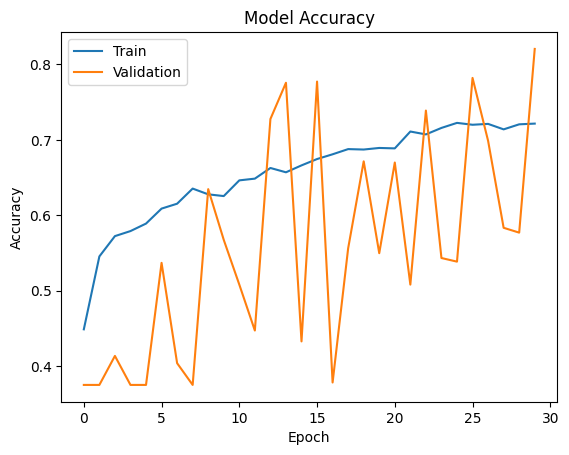

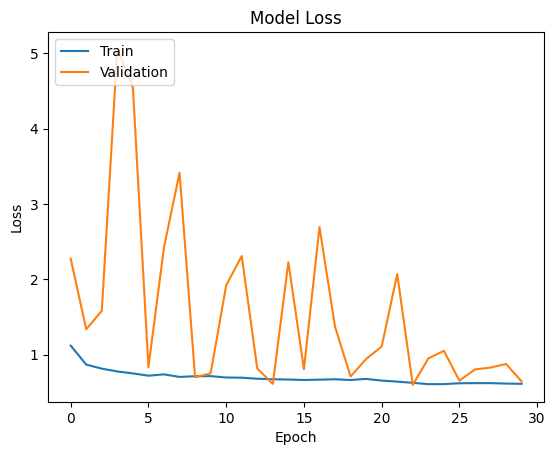

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
# Predictions and metrics
test.reset()
preds = model.predict(test, verbose=1)
predicted_classes = np.argmax(preds, axis=1)
true_classes = test.classes
class_labels = list(test.class_indices.keys())

20/20 [==============================] - 8s 359ms/step


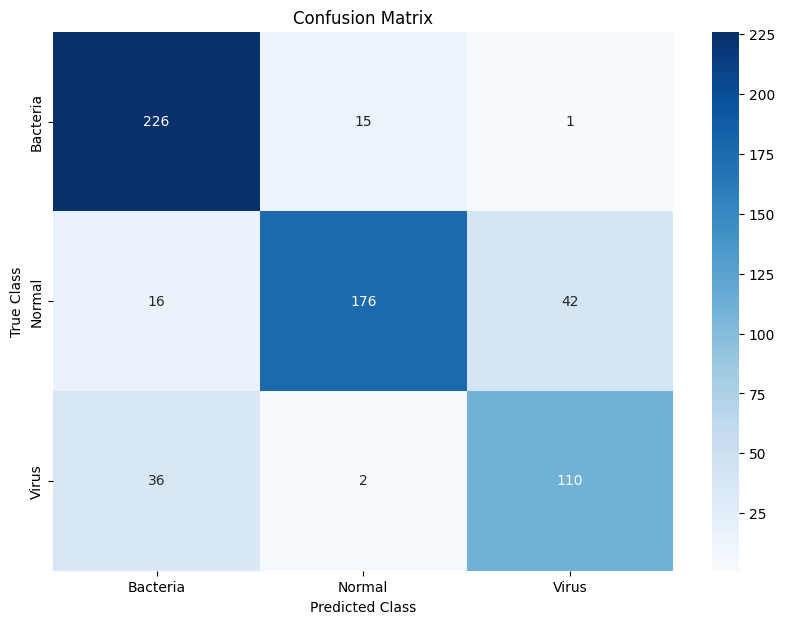

In [17]:
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [18]:
cr = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", cr)

Classification Report:
               precision    recall  f1-score   support

    Bacteria       0.81      0.93      0.87       242
      Normal       0.91      0.75      0.82       234
       Virus       0.72      0.74      0.73       148

    accuracy                           0.82       624
   macro avg       0.81      0.81      0.81       624
weighted avg       0.83      0.82      0.82       624

